In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path='/content/drive/MyDrive/Tomato'

In [3]:
import tensorflow as tf
from tensorflow.keras import models,KerasTensor
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(256,256),
    batch_size=32,

)

Found 1556 files belonging to 10 classes.


In [5]:
class_names = dataset.class_names

In [6]:
print(class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


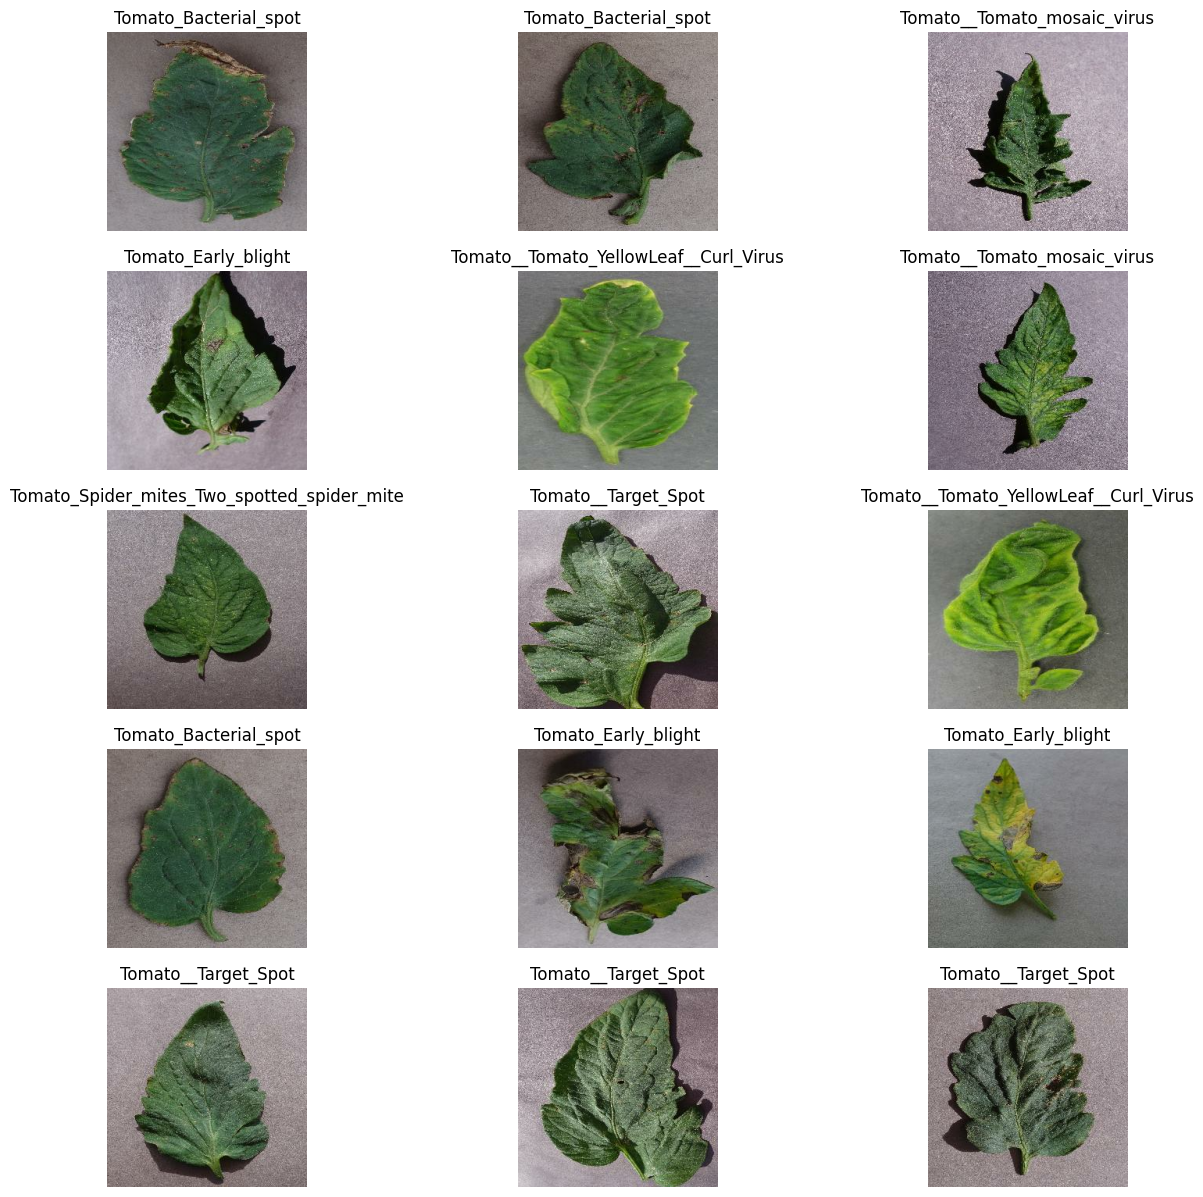

In [7]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(5,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(256,256),
  tf.keras.layers.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),

])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (32, 256,256,3)

model = models.Sequential([
    resize_and_rescale,


    layers.Conv2D(32,kernel_size = (3,3),activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,kernel_size = (3,3),activation='relu',),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])
model.build(input_shape=input_shape)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 2304)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

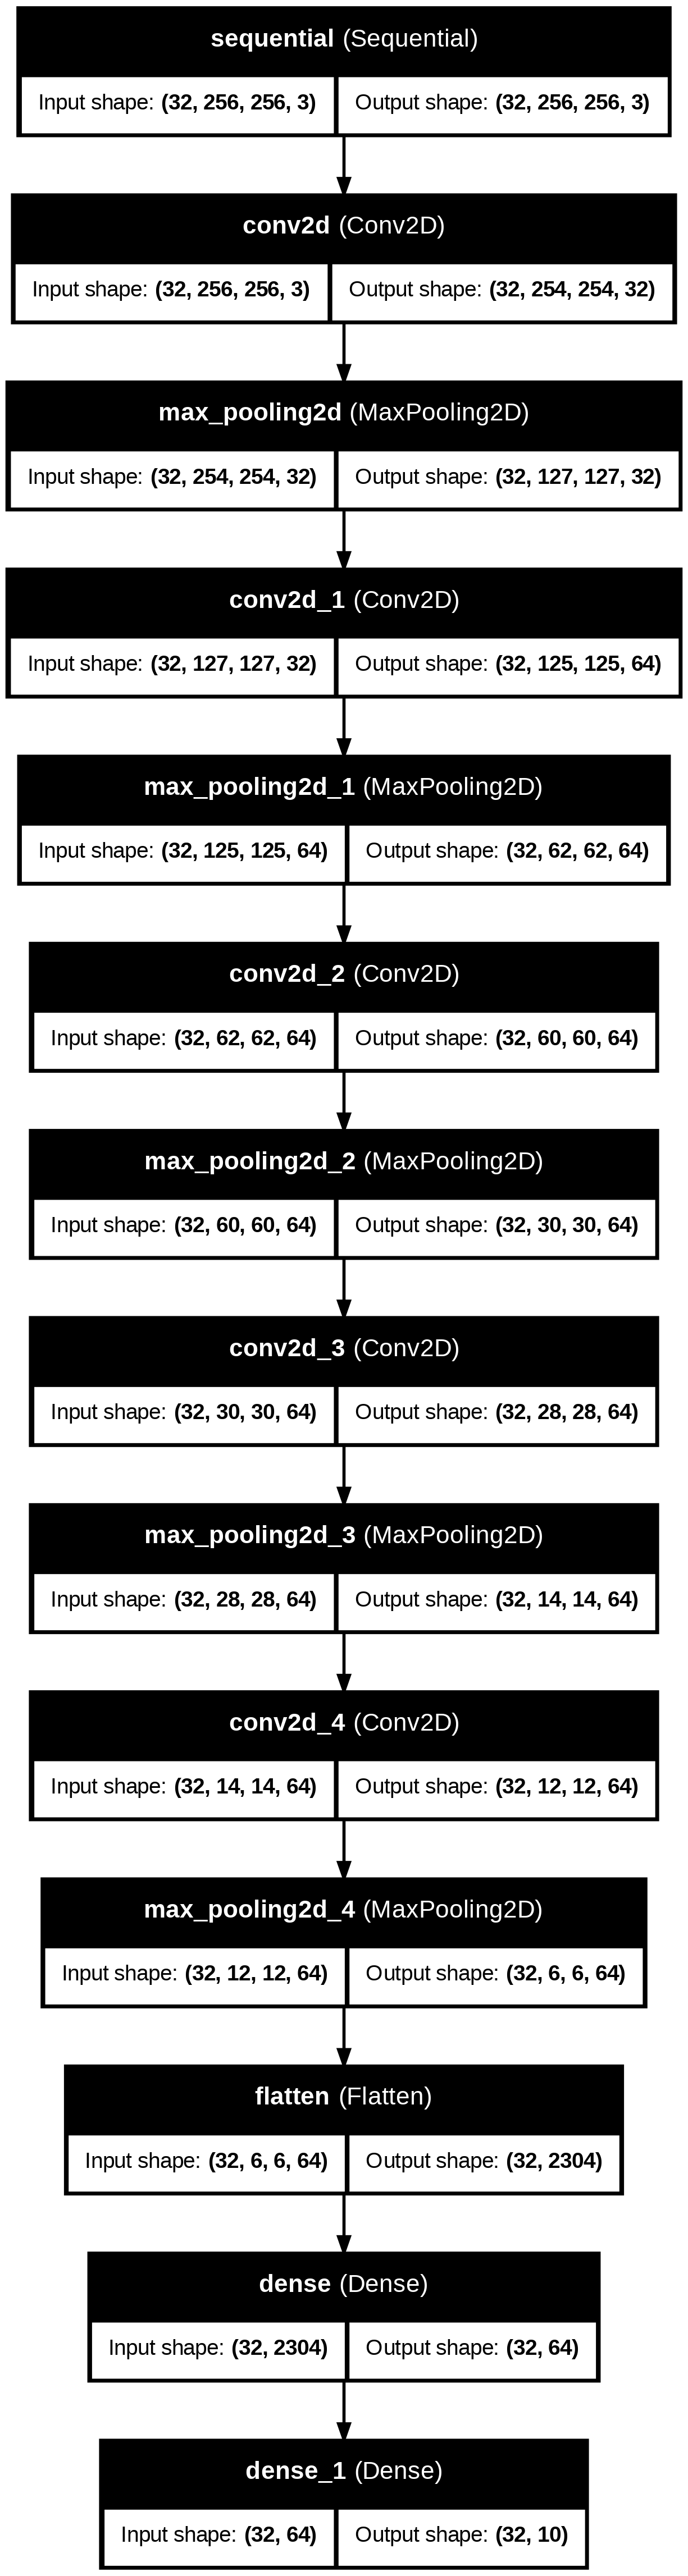

In [16]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    verbose=1,
    epochs=100,
)

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 459s 733ms/step - accuracy: 0.1628 - loss: 2.2593 - val_accuracy: 0.1953 - val_loss: 2.0587
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.2616 - loss: 1.9999 - val_accuracy: 0.4141 - val_loss: 1.7909
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 353ms/step - accuracy: 0.3858 - loss: 1.7708 - val_accuracy: 0.4062 - val_loss: 1.6913
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 356ms/step - accuracy: 0.4633 - loss: 1.5264 - val_accuracy: 0.2578 - val_loss: 2.3756
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 355ms/step - accuracy: 0.4549 - loss: 1.5002 - val_accuracy: 0.4609 - val_loss: 1.6705
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 363ms/step - accuracy: 0.5449 - loss: 1.3010 - val_accuracy: 0.5000 - val_loss: 1.9081
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.5784 - loss: 1.1707 - val_accuracy: 0.4219 - val_loss: 2.1537
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.6183 - loss: 1.0878 -

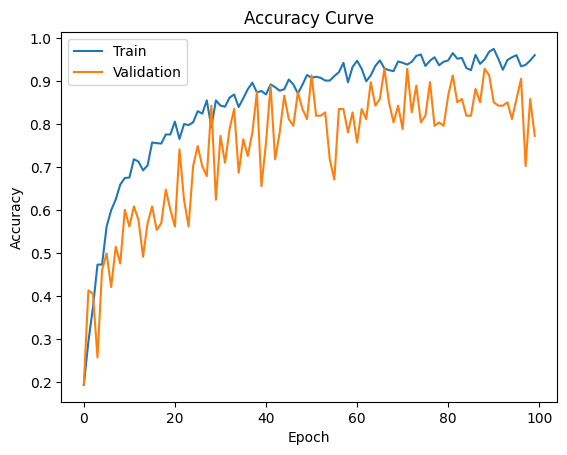

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
from tensorflow.keras.models import load_model
model.save('model.h5')

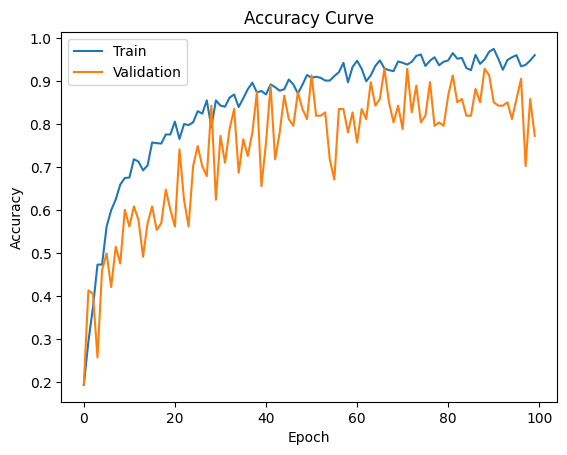

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Curve')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

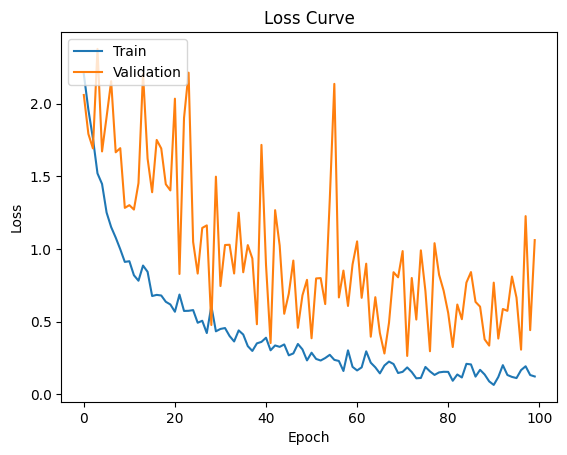

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [24]:
history.history['loss'][:]

[2.2022202014923096,
 1.9575331211090088,
 1.7595148086547852,
 1.5193231105804443,
 1.446612000465393,
 1.2498332262039185,
 1.1500788927078247,
 1.077678918838501,
 0.9974219799041748,
 0.9103778004646301,
 0.9151955842971802,
 0.818666398525238,
 0.7809699773788452,
 0.8853666186332703,
 0.8422489166259766,
 0.6756694316864014,
 0.6835660934448242,
 0.6793140769004822,
 0.6360554099082947,
 0.6175153851509094,
 0.5675082206726074,
 0.685733437538147,
 0.5731165409088135,
 0.5740347504615784,
 0.5789512395858765,
 0.4918114244937897,
 0.505469799041748,
 0.4210292100906372,
 0.6062553524971008,
 0.4329608380794525,
 0.4492153823375702,
 0.4554281532764435,
 0.4006456434726715,
 0.3631138503551483,
 0.439134806394577,
 0.4107298254966736,
 0.3310353457927704,
 0.29779428243637085,
 0.35003870725631714,
 0.3602196276187897,
 0.38881632685661316,
 0.30236777663230896,
 0.33561375737190247,
 0.3260009288787842,
 0.3426160216331482,
 0.26774245500564575,
 0.28092387318611145,
 0.345796644

In [25]:
history.history['accuracy'][:]

[0.19417475163936615,
 0.29449838399887085,
 0.3745954632759094,
 0.47411003708839417,
 0.47411003708839417,
 0.5622977614402771,
 0.6003236174583435,
 0.6254045367240906,
 0.6601941585540771,
 0.6755663156509399,
 0.6763753890991211,
 0.7192556858062744,
 0.7135922312736511,
 0.6933656930923462,
 0.704692542552948,
 0.758090615272522,
 0.7564724683761597,
 0.7556634545326233,
 0.7766990065574646,
 0.7766990065574646,
 0.8066343069076538,
 0.766181230545044,
 0.8009708523750305,
 0.7985436916351318,
 0.8050161600112915,
 0.8309061527252197,
 0.8252426981925964,
 0.8559870719909668,
 0.7936893105506897,
 0.8559870719909668,
 0.8438511490821838,
 0.8414239287376404,
 0.8624595403671265,
 0.8697410821914673,
 0.840614914894104,
 0.8608414530754089,
 0.8818770051002502,
 0.897249162197113,
 0.8745954632759094,
 0.8778316974639893,
 0.8697410821914673,
 0.893203854560852,
 0.8867313861846924,
 0.8786407709121704,
 0.8818770051002502,
 0.9045307636260986,
 0.893203854560852,
 0.8721683025360

In [26]:
history.history['val_loss'][:]

[2.058717966079712,
 1.790872573852539,
 1.691256046295166,
 2.375579357147217,
 1.6704667806625366,
 1.908066749572754,
 2.153696298599243,
 1.6644368171691895,
 1.6928967237472534,
 1.2821258306503296,
 1.3006908893585205,
 1.270434021949768,
 1.4525556564331055,
 2.2064688205718994,
 1.621301293373108,
 1.3896383047103882,
 1.7495790719985962,
 1.690680980682373,
 1.4446394443511963,
 1.4021625518798828,
 2.033304214477539,
 0.8273109197616577,
 1.900754690170288,
 2.212177276611328,
 1.0478503704071045,
 0.8301878571510315,
 1.1441435813903809,
 1.1616131067276,
 0.47625353932380676,
 1.4968043565750122,
 0.7442676424980164,
 1.026639699935913,
 1.028377652168274,
 0.8306955099105835,
 1.249045729637146,
 0.8391604423522949,
 1.0260248184204102,
 0.9338918328285217,
 0.48151496052742004,
 1.715416669845581,
 0.8904298543930054,
 0.35207605361938477,
 1.2663217782974243,
 1.0229171514511108,
 0.5536524653434753,
 0.6918270587921143,
 0.9195566177368164,
 0.45717960596084595,
 0.6801

In [27]:
history.history['val_accuracy'][:]

[0.1953125,
 0.4140625,
 0.40625,
 0.2578125,
 0.4609375,
 0.5,
 0.421875,
 0.515625,
 0.4765625,
 0.6015625,
 0.5625,
 0.609375,
 0.578125,
 0.4921875,
 0.5703125,
 0.609375,
 0.5546875,
 0.5703125,
 0.6484375,
 0.6015625,
 0.5625,
 0.7421875,
 0.625,
 0.5625,
 0.703125,
 0.75,
 0.703125,
 0.6796875,
 0.84375,
 0.625,
 0.7734375,
 0.7109375,
 0.7890625,
 0.8359375,
 0.6875,
 0.765625,
 0.7265625,
 0.78125,
 0.875,
 0.65625,
 0.7578125,
 0.890625,
 0.71875,
 0.78125,
 0.8671875,
 0.8125,
 0.796875,
 0.875,
 0.8359375,
 0.8125,
 0.9140625,
 0.8203125,
 0.8203125,
 0.828125,
 0.71875,
 0.671875,
 0.8359375,
 0.8359375,
 0.78125,
 0.828125,
 0.7578125,
 0.8359375,
 0.8125,
 0.8984375,
 0.84375,
 0.859375,
 0.9296875,
 0.8515625,
 0.8046875,
 0.84375,
 0.7890625,
 0.9296875,
 0.828125,
 0.890625,
 0.8046875,
 0.8203125,
 0.8984375,
 0.796875,
 0.8046875,
 0.796875,
 0.8671875,
 0.9140625,
 0.8515625,
 0.859375,
 0.8203125,
 0.8203125,
 0.8828125,
 0.8515625,
 0.9296875,
 0.9140625,
 0.8515

first image to predict
actual label: Tomato__Target_Spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
predicted label: Tomato_healthy
Time taken for prediction: 0.9596 seconds


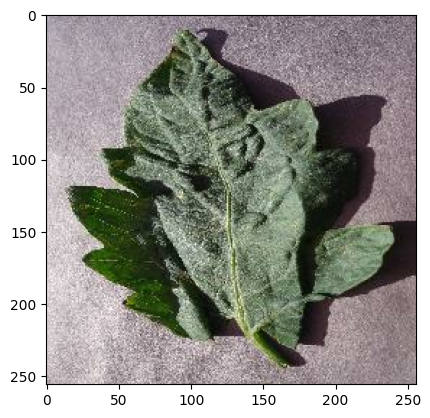

In [28]:
import numpy as np
import time
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    start_time = time.time()
    batch_prediction = model.predict(images_batch)
    end_time = time.time()
    prediction_time = end_time - start_time
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    print(f"Time taken for prediction: {prediction_time:.4f} seconds")

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [30]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
   y_true.append(label_batch)
   #y_true.append(np.argmax(y_true, axis = 0))
   preds = model.predict(image_batch)
   y_pred.append(np.argmax(preds, axis = - 1))

true_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [31]:
true_labels

<tf.Tensor: shape=(192,), dtype=int32, numpy=
array([1, 6, 2, 7, 3, 9, 0, 8, 4, 9, 2, 2, 7, 6, 7, 8, 8, 6, 0, 6, 2, 4,
       3, 6, 6, 8, 4, 1, 8, 1, 9, 0, 1, 2, 3, 8, 6, 9, 2, 5, 7, 7, 8, 0,
       0, 9, 6, 8, 9, 6, 9, 4, 9, 9, 6, 0, 0, 5, 9, 8, 9, 7, 1, 8, 2, 8,
       1, 9, 8, 1, 1, 8, 1, 1, 0, 9, 7, 3, 5, 6, 9, 0, 3, 4, 2, 7, 1, 2,
       6, 8, 1, 6, 3, 8, 7, 8, 6, 7, 0, 3, 3, 8, 2, 0, 4, 8, 6, 6, 1, 6,
       4, 0, 0, 2, 8, 7, 7, 0, 8, 6, 0, 8, 6, 0, 6, 4, 5, 4, 6, 3, 2, 2,
       2, 3, 3, 0, 3, 6, 6, 4, 8, 8, 0, 9, 6, 8, 9, 1, 9, 0, 3, 7, 6, 9,
       7, 9, 4, 9, 3, 9, 7, 6, 4, 0, 9, 6, 6, 6, 8, 7, 0, 6, 9, 9, 9, 8,
       8, 4, 6, 4, 6, 0, 9, 9, 3, 2, 0, 3, 9, 9, 2, 6], dtype=int32)>

In [32]:
predicted_labels

<tf.Tensor: shape=(192,), dtype=int64, numpy=
array([6, 6, 2, 0, 3, 9, 0, 8, 4, 9, 9, 2, 5, 9, 7, 8, 8, 6, 0, 9, 9, 4,
       4, 6, 9, 9, 4, 1, 9, 1, 9, 0, 1, 2, 3, 8, 6, 9, 9, 9, 7, 7, 8, 1,
       0, 9, 6, 8, 9, 9, 9, 6, 9, 9, 6, 0, 0, 6, 9, 9, 9, 5, 1, 8, 2, 8,
       1, 9, 9, 1, 1, 8, 1, 1, 0, 9, 7, 3, 5, 9, 9, 0, 4, 1, 2, 7, 1, 6,
       6, 8, 1, 6, 3, 9, 7, 8, 9, 6, 0, 4, 4, 9, 2, 0, 9, 8, 6, 9, 1, 6,
       4, 0, 0, 2, 9, 7, 7, 0, 6, 9, 0, 8, 9, 0, 6, 4, 5, 6, 9, 3, 2, 2,
       2, 3, 3, 0, 5, 6, 6, 4, 9, 8, 0, 9, 6, 8, 9, 1, 9, 0, 3, 7, 9, 9,
       7, 9, 4, 9, 3, 9, 5, 5, 9, 0, 9, 9, 9, 9, 9, 7, 0, 6, 9, 9, 9, 9,
       8, 4, 9, 4, 6, 0, 9, 9, 3, 2, 1, 3, 9, 9, 2, 9])>

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_labels, true_labels)

In [34]:
cm

array([[21,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 2, 13,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 11,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  2,  1,  3,  0,  0],
       [ 0,  1,  1,  0,  2,  1, 16,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 16,  0],
       [ 0,  0,  3,  0,  2,  1, 16,  0, 10, 29]])

Text(95.72222222222221, 0.5, 'Truth')

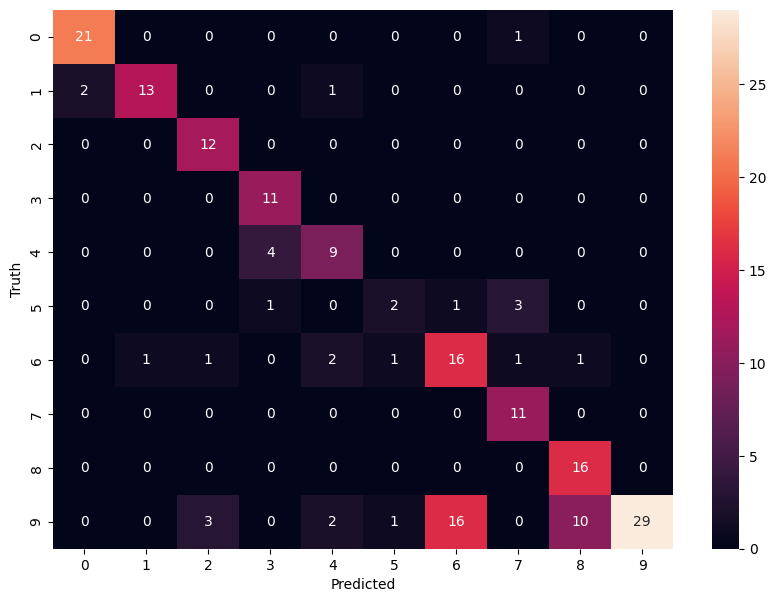

In [35]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [38]:
from sklearn.metrics import classification_report
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93        23
           1       0.81      0.93      0.87        14
           2       1.00      0.75      0.86        16
           3       1.00      0.69      0.81        16
           4       0.69      0.64      0.67        14
           5       0.29      0.50      0.36         4
           6       0.70      0.48      0.57        33
           7       1.00      0.69      0.81        16
           8       1.00      0.59      0.74        27
           9       0.48      1.00      0.64        29

    accuracy                           0.73       192
   macro avg       0.79      0.72      0.73       192
weighted avg       0.81      0.73      0.74       192

